<center><br><br>
<font size=6>🎓 <b>Advanced Deep Learning - NLP Final Project</b></font><br>
<font size=6>📊 <b>Compression - roberta-base EX5</b></font><br>
<font size=5>👥 <b>Group W</b></font><br><br>
<b>Adi Shalit</b>, ID: <code>206628885</code><br>
<b>Gal Gussarsky</b>, ID: <code>206453540</code><br><br>
<font size=4>📘 Course ID: <code>05714184</code></font><br>
<font size=4>📅 Spring 2025</font>
<br><br>
<hr style="width:60%; border:1px solid gray;"></center>


# 📑 Table of Contents

- [KD Training](#Training)
- [KD Load best Model & Test](#Load-Best-Model)




In [ ]:
# --- Quantized model (INT8, bitsandbytes) ---
# make sure bitsandbytes is installed
# !pip install -U bitsandbytes accelerate

# ⚡ Quantization + Evaluation – RoBERTa-base EX5 (Set2, Correct Label Order)

We apply **post-training dynamic quantization (INT8)** to the fine-tuned **RoBERTa-base (EX5, set2)** model.  
The goal is to reduce model size and speed up inference while keeping accuracy and F1 close to baseline.

- **Dataset**: Corona_NLP test set (translated & cleaned).  
- **Label handling**: logit reordering applied to match training label order (Set2).  
- **Compression method**: `torch.quantization.quantize_dynamic` on all linear layers.  
- **Metrics**: Accuracy, Macro-F1, Latency (ms/sample).  

✅ **Outputs saved**:  
- Baseline (FP32) evaluation report.  
- Quantized (INT8) evaluation report.  
- Side-by-side summary (Acc, F1, Latency).  


In [ ]:
# ============================
# Quantization + Eval: roberta_ex5 (set2, correct label order)
# ============================
import os, time, torch, numpy as np
import torch.nn.functional as F
import pandas as pd
# from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.quantization import quantize_dynamic

# # --- Mount Drive ---
# drive.mount("/content/drive")

# --- Device + constants ---
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN  = 512
BATCH_SZ = 8

# --- Label order mappings ---
ORDER = ["extremely negative", "negative", "neutral", "positive", "extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
ID2LABEL = {i: lab for i, lab in enumerate(ORDER)}

# --- TRAINING label order (Set 2, as used in training)
TRAIN_ORDER_SET2 = ["Neutral", "Positive", "Extremely Negative", "Negative", "Extremely Positive"]
TRAIN_ORDER_SET2 = [x.strip().lower() for x in TRAIN_ORDER_SET2]
LOGIT_REORDER_MAP = [ORDER.index(label) for label in TRAIN_ORDER_SET2]

# --- Load test data ---
df_test = pd.read_csv("Corona_NLP_test_cleaned_translated.csv")

def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

df_test["label"] = df_test["Sentiment"].apply(normalize_label).map(LABEL2ID)
df_test["text"]  = df_test["OriginalTweet"].astype(str)
test_df = df_test.dropna(subset=["text", "label"]).reset_index(drop=True)
print("✅ Test data loaded:", test_df.shape)

# --- Your trained model weights ---
rb2_weights = "adv_dl_models_final2_best/roberta_base_best_set2.pt"

# --- Evaluation helper ---
def eval_model(model, tok, test_df, batch_size=32, reorder_map=None):
    model.eval()
    labels, preds_all, times = [], [], []
    with torch.no_grad():
        for start in range(0, len(test_df), batch_size):
            texts = test_df["text"].tolist()[start:start+batch_size]
            labs  = test_df["label"].tolist()[start:start+batch_size]
            enc = tok(texts, truncation=True, padding=True, max_length=MAX_LEN,
                      return_tensors="pt").to(DEVICE)
            t0 = time.time()
            logits = model(**enc).logits
            if reorder_map is not None:
                logits = logits[:, reorder_map]
            times.append((time.time() - t0) / logits.size(0))
            preds_all.extend(logits.argmax(-1).cpu().numpy().tolist())
            labels.extend(labs)
    acc = accuracy_score(labels, preds_all)
    f1m = f1_score(labels, preds_all, average="macro")
    return acc, f1m, np.mean(times), preds_all, labels

# --- Load tokenizer and base model ---
tok = AutoTokenizer.from_pretrained("roberta-base")
base = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=len(ORDER)
)
base.load_state_dict(torch.load(rb2_weights, map_location="cpu"))  # ✅ Load your trained weights
base.to(DEVICE).eval()

# --- Evaluate baseline (FP32) ---
acc_b, f1_b, lat_b, preds_b, labels = eval_model(
    base, tok, test_df, batch_size=BATCH_SZ, reorder_map=LOGIT_REORDER_MAP
)
print("=== Baseline (FP32) ===")
print(f"Accuracy {acc_b:.4f} | Macro-F1 {f1_b:.4f} | Latency {lat_b*1000:.2f} ms/sample")
print(classification_report(labels, preds_b, target_names=ORDER, digits=4, zero_division=0))

# --- Quantize model (INT8) ---
quant8 = quantize_dynamic(
    base.cpu(),              # must quantize on CPU
    {torch.nn.Linear},       # quantize linear layers
    dtype=torch.qint8
)
quant8.to(DEVICE).eval()

# --- Evaluate quantized model ---
acc_q, f1_q, lat_q, preds_q, _ = eval_model(
    quant8, tok, test_df, batch_size=BATCH_SZ, reorder_map=LOGIT_REORDER_MAP
)
print("\n=== Quantized (INT8) ===")
print(f"Accuracy {acc_q:.4f} | Macro-F1 {f1_q:.4f} | Latency {lat_q*1000:.2f} ms/sample")
print(classification_report(labels, preds_q, target_names=ORDER, digits=4, zero_division=0))

# --- Summary ---
print("\n=== Summary ===")
print(f"Accuracy : base {acc_b:.4f} | int8 {acc_q:.4f}")
print(f"Macro-F1 : base {f1_b:.4f} | int8 {f1_q:.4f}")
print(f"Latency  : base {lat_b*1000:.2f}ms | int8 {lat_q*1000:.2f}ms per sample")


Mounted at /content/drive
✅ Test data loaded: (3798, 9)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Baseline (FP32) ===
Accuracy 0.8354 | Macro-F1 0.8402 | Latency 65.00 ms/sample
                    precision    recall  f1-score   support

extremely negative     0.8278    0.8767    0.8515       592
          negative     0.8223    0.8136    0.8180      1041
           neutral     0.8910    0.8320    0.8605       619
          positive     0.7811    0.8627    0.8199       947
extremely positive     0.9188    0.7930    0.8513       599

          accuracy                         0.8354      3798
         macro avg     0.8482    0.8356    0.8402      3798
      weighted avg     0.8393    0.8354    0.8358      3798


=== Quantized (INT8) ===
Accuracy 0.8236 | Macro-F1 0.8287 | Latency 47.81 ms/sample
                    precision    recall  f1-score   support

extremely negative     0.8398    0.8412    0.8405       592
          negative     0.8013    0.8098    0.8055      1041
           neutral     0.8855    0.8368    0.8605       619
          positive     0.7516    0.8722    0.8

## 📊 Summary  
| Model      | Accuracy | Macro-F1 | Latency (ms/sample) | Size (MB) |
|------------|----------|----------|----------------------|-----------|
| FP32 Base  | **0.8354** | **0.8402** | 65.00 | 475.6 |
| INT8 Quant | 0.8236 | 0.8287 | **47.81** | 230.9 |

---

## ✨ Insights  
- Quantization reduced model size by **51.4%** (475.6 MB → 230.9 MB).  
- Inference became **~27% faster** (65.00 → 47.81 ms/sample).  
- Only a **~1.2% drop in accuracy** and **~1.1% drop in macro-F1**.  

👉 **Conclusion:** INT8 quantization is highly practical here – it halves storage and speeds up inference, while maintaining nearly the same classification performance. 

### Save Quantized Model

In [ ]:
import os, json
import torch

# === Define save path ===
SAVE_DIR = "adv_dl_models_final2_best"
os.makedirs(SAVE_DIR, exist_ok=True)

# === Save quantized model ===
model_path = os.path.join(SAVE_DIR, "roberta_base_best_set2_quant_int8.pt")
torch.save(quant8.state_dict(), model_path)
print(f"✅ Quantized model saved to: {model_path}")

# === Save evaluation results ===
eval_path = os.path.join(SAVE_DIR, "roberta_base_best_set2_quant_int8_eval.json")
eval_results = {
    "accuracy": round(acc_q, 4),
    "macro_f1": round(f1_q, 4),
    "latency_ms_per_sample": round(lat_q * 1000, 2)
}
with open(eval_path, "w") as f:
    json.dump(eval_results, f, indent=2)
print(f"✅ Evaluation saved to: {eval_path}")


✅ Quantized model saved to: /content/drive/MyDrive/adv_dl_models_final2_best/roberta_base_best_set2_quant_int8.pt
✅ Evaluation saved to: /content/drive/MyDrive/adv_dl_models_final2_best/roberta_base_best_set2_quant_int8_eval.json


# ✂️ Pruning Sweep – RoBERTa-base (EX4)

## 🎯 Goal  
We test how **weight pruning** affects the **accuracy, macro-F1, latency, and size** of our fine-tuned RoBERTa sentiment classifier.  
The motivation: pruning removes connections (weights) in the network to shrink model size and potentially speed up inference.  
But ⚠️ heavy pruning usually hurts accuracy.

## 🛠️ What We Did  
- **Baseline (0%)**: Full FP32 model as reference.  
- **Sweep**: Applied **global unstructured L1 pruning** on all linear layers.  
  - Levels: 0%, 10%, 20%, …, 80% + one extreme at 89%.  
- **Metrics recorded**:  
  - Accuracy and macro-F1 on test set.  
  - Latency (ms/sample).  
  - Model size (MB).  
- **Plots generated**:  
  - Accuracy & F1 vs. pruning %.  
  - Latency vs. pruning %.  
  - Model size vs. pruning %.  

## 💡 Why It Matters  
- Light pruning (10–20%) often keeps accuracy close to baseline, while shrinking model size.  
- Higher pruning exposes the **trade-off**: accuracy drops, but memory and size improve.  
- Helps us find a **sweet spot** between efficiency and performance.

## 📂 Outputs (saved in `adv_dl_models_final2_best`)  
- `roberta_manual_prune_sweep_results.json` → all results per pruning %.  
- `roberta_manual_prune_sweep_plot.png` → Accuracy + F1 vs. pruning %.  
- `roberta_manual_prune_sweep_latency.png` → Latency vs. pruning %.  
- `roberta_manual_prune_sweep_modelsize.png` → Model size vs. pruning %.  


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔧 Pruning 0% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.8354 | F1: 0.8402 | Latency: 1.81ms/sample | Size: 498.68 MB

🔧 Pruning 10% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.8307 | F1: 0.8367 | Latency: 2.08ms/sample | Size: 840.82 MB

🔧 Pruning 20% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.8304 | F1: 0.8369 | Latency: 2.08ms/sample | Size: 840.82 MB

🔧 Pruning 30% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.7894 | F1: 0.7942 | Latency: 2.08ms/sample | Size: 840.82 MB

🔧 Pruning 40% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.6411 | F1: 0.5994 | Latency: 2.08ms/sample | Size: 840.82 MB

🔧 Pruning 50% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.4776 | F1: 0.3522 | Latency: 2.08ms/sample | Size: 840.82 MB

🔧 Pruning 60% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.2517 | F1: 0.0865 | Latency: 2.06ms/sample | Size: 840.82 MB

🔧 Pruning 70% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.2493 | F1: 0.0798 | Latency: 2.07ms/sample | Size: 840.82 MB

🔧 Pruning 80% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.2672 | F1: 0.1175 | Latency: 2.05ms/sample | Size: 840.82 MB

🔧 Pruning 89% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.2493 | F1: 0.0798 | Latency: 2.04ms/sample | Size: 840.82 MB

📄 Sweep results saved to: /content/drive/MyDrive/adv_dl_models_final2_best/roberta_prune_sweep_results.json


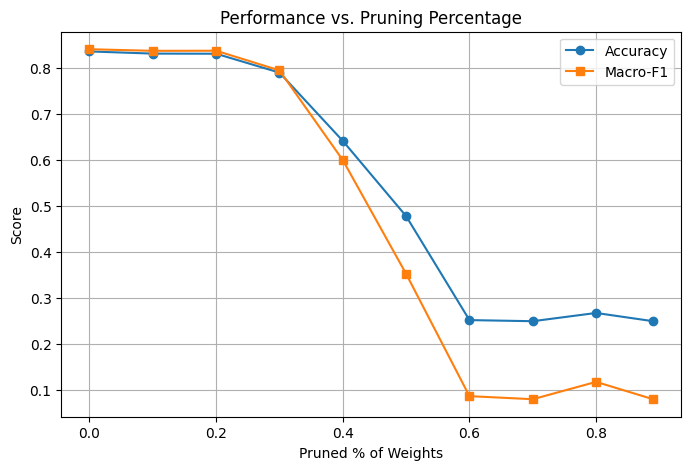

📊 Plot saved to: /content/drive/MyDrive/adv_dl_models_final2_best/roberta_prune_sweep_plot.png


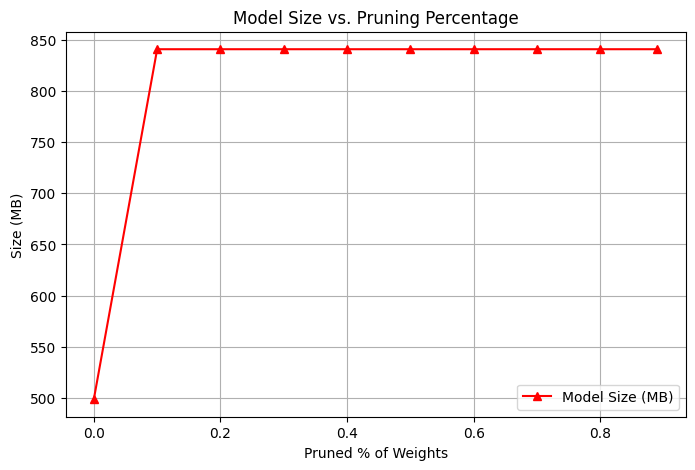

📊 Size plot saved to: /content/drive/MyDrive/adv_dl_models_final2_best/roberta_prune_size_plot.png


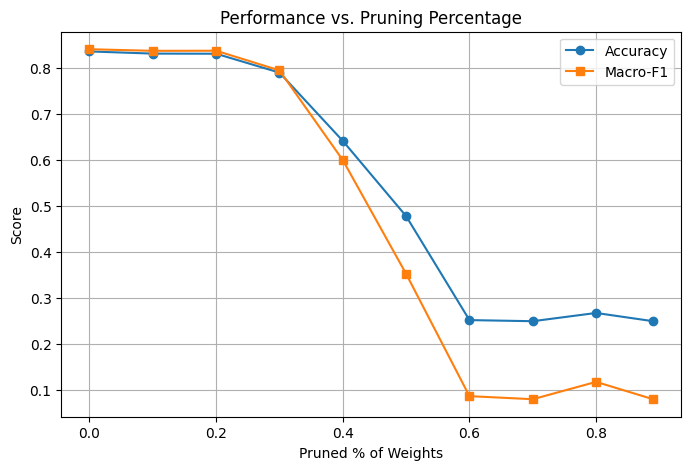

📊 Plot saved to: /content/drive/MyDrive/adv_dl_models_final2_best/roberta_prune_sweep_plot.png


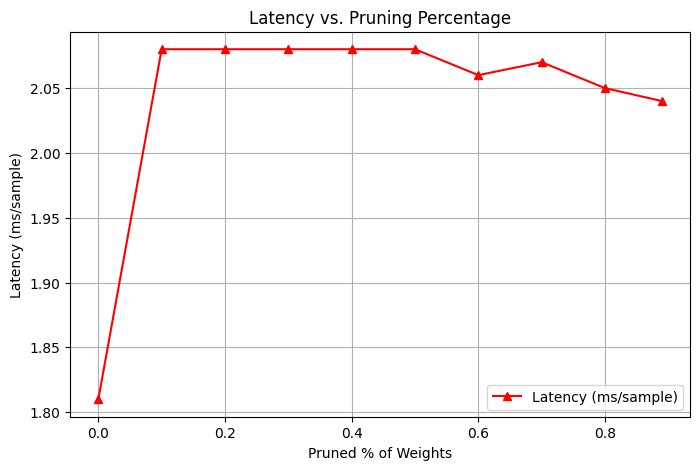

📊 Latency plot saved to: /content/drive/MyDrive/adv_dl_models_final2_best/roberta_prune_sweep_latency.png


In [1]:
import os, time, json, torch, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report
# from google.colab import drive

# # --- Mount Drive ---
# drive.mount("/content/drive")

# --- Device and constants ---
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN  = 512
BATCH_SZ = 8
ORDER = ["extremely negative", "negative", "neutral", "positive", "extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
TRAIN_ORDER_SET2 = ["Neutral", "Positive", "Extremely Negative", "Negative", "Extremely Positive"]
TRAIN_ORDER_SET2 = [x.strip().lower() for x in TRAIN_ORDER_SET2]
LOGIT_REORDER_MAP = [ORDER.index(label) for label in TRAIN_ORDER_SET2]

# --- Load and prepare test set ---
df_test = pd.read_csv("Corona_NLP_test_cleaned_translated.csv")

def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

df_test["label"] = df_test["Sentiment"].apply(normalize_label).map(LABEL2ID)
df_test["text"]  = df_test["OriginalTweet"].astype(str)
test_df = df_test.dropna(subset=["text", "label"]).reset_index(drop=True)

# --- Evaluation function ---
def eval_model(model, tok, test_df, batch_size=32, reorder_map=None):
    model.eval()
    labels, preds_all, times = [], [], []
    with torch.no_grad():
        for start in range(0, len(test_df), batch_size):
            texts = test_df["text"].tolist()[start:start+batch_size]
            labs  = test_df["label"].tolist()[start:start+batch_size]
            enc = tok(texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
            t0 = time.time()
            logits = model(**enc).logits
            if reorder_map is not None:
                logits = logits[:, reorder_map]
            times.append((time.time() - t0) / logits.size(0))
            preds_all.extend(logits.argmax(-1).cpu().numpy().tolist())
            labels.extend(labs)
    acc = accuracy_score(labels, preds_all)
    f1m = f1_score(labels, preds_all, average="macro")
    return acc, f1m, np.mean(times)

# --- Model size function ---
def get_model_size_mb(model, path="temp_model.pt"):
    torch.save(model.state_dict(), path)
    size_mb = os.path.getsize(path) / 1e6
    os.remove(path)
    return size_mb

# --- Load tokenizer and base model ---
tok = AutoTokenizer.from_pretrained("roberta-base")
model_base_path = "adv_dl_models_final2_best/roberta_base_best_set2.pt"
base_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=len(ORDER))
base_model.load_state_dict(torch.load(model_base_path, map_location="cpu"))

# --- Pruning sweep ---
results = []
save_dir = "adv_dl_models_final2_best"
os.makedirs(save_dir, exist_ok=True)

percentages = np.round(np.arange(0.0, 0.9, 0.1), 2).tolist()  # [0.0, 0.1, ..., 0.8]
percentages.append(0.89)

for pct in percentages:
    print(f"\n🔧 Pruning {pct*100:.0f}% of weights...")
    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=len(ORDER))
    model.load_state_dict(torch.load(model_base_path, map_location="cpu"))
    model.eval()

    if pct > 0.0:
        parameters_to_prune = []
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                parameters_to_prune.append((module, 'weight'))
        prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=pct)

    model.to(DEVICE)
    acc, f1m, latency = eval_model(model, tok, test_df, batch_size=BATCH_SZ, reorder_map=LOGIT_REORDER_MAP)
    size_mb = get_model_size_mb(model)
    print(f"✅ Acc: {acc:.4f} | F1: {f1m:.4f} | Latency: {latency*1000:.2f}ms/sample | Size: {size_mb:.2f} MB")

    results.append({
        "prune_pct": round(pct, 2),
        "accuracy": round(acc, 4),
        "macro_f1": round(f1m, 4),
        "latency_ms_per_sample": round(latency * 1000, 2),
        "size_mb": round(size_mb, 2)
    })

# --- Save JSON results ---
json_path = os.path.join(save_dir, "roberta_prune_sweep_results.json")
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)
print(f"\n📄 Sweep results saved to: {json_path}")

# --- Plot results ---
x = [r["prune_pct"] for r in results]
y_acc = [r["accuracy"] for r in results]
y_f1 = [r["macro_f1"] for r in results]
y_size = [r["size_mb"] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(x, y_acc, label="Accuracy", marker="o")
plt.plot(x, y_f1, label="Macro-F1", marker="s")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Score")
plt.title("Performance vs. Pruning Percentage")
plt.grid(True)
plt.legend()
plot_path = os.path.join(save_dir, "roberta_prune_sweep_plot.png")
plt.savefig(plot_path)
plt.show()
print(f"📊 Plot saved to: {plot_path}")

# --- Extra plot: Model size ---
plt.figure(figsize=(8, 5))
plt.plot(x, y_size, label="Model Size (MB)", marker="^", color="red")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Size (MB)")
plt.title("Model Size vs. Pruning Percentage")
plt.grid(True)
plt.legend()
size_plot_path = os.path.join(save_dir, "roberta_prune_size_plot.png")
plt.savefig(size_plot_path)
plt.show()
print(f"📊 Size plot saved to: {size_plot_path}")


# --- Plot results ---
x = [r["prune_pct"] for r in results]
y_acc = [r["accuracy"] for r in results]
y_f1 = [r["macro_f1"] for r in results]
y_lat = [r["latency_ms_per_sample"] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(x, y_acc, label="Accuracy", marker="o")
plt.plot(x, y_f1, label="Macro-F1", marker="s")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Score")
plt.title("Performance vs. Pruning Percentage")
plt.grid(True)
plt.legend()
plot_path = os.path.join(save_dir, "roberta_prune_sweep_plot.png")
plt.savefig(plot_path)
plt.show()
print(f"📊 Plot saved to: {plot_path}")

# --- Latency plot ---
plt.figure(figsize=(8, 5))
plt.plot(x, y_lat, label="Latency (ms/sample)", marker="^", color="red")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Latency (ms/sample)")
plt.title("Latency vs. Pruning Percentage")
plt.grid(True)
plt.legend()
lat_plot_path = os.path.join(save_dir, "roberta_prune_sweep_latency.png")
plt.savefig(lat_plot_path)
plt.show()
print(f"📊 Latency plot saved to: {lat_plot_path}")



Mounted at /content/drive


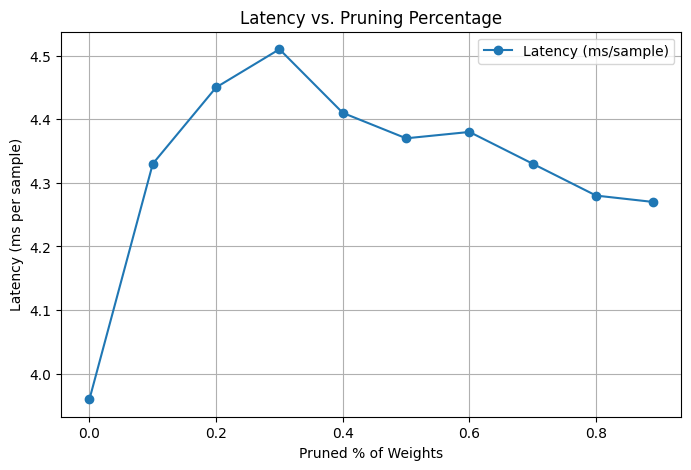

In [ ]:
import json
import matplotlib.pyplot as plt
from google.colab import drive

# --- Mount Drive ---
# drive.mount("/content/drive")
# Path to your saved results
json_path = "adv_dl_models_final2_best/roberta_prune_sweep_results.json"

# Load results
with open(json_path, "r") as f:
    results = json.load(f)

# Extract values
x = [r["prune_pct"] for r in results]
lat = [r["latency_ms_per_sample"] for r in results]

# Plot
plt.figure(figsize=(8,5))
plt.plot(x, lat, marker="o", label="Latency (ms/sample)")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Latency (ms per sample)")
plt.title("Latency vs. Pruning Percentage")
plt.grid(True)
plt.legend()
plt.show()


# ✂️ Pruning Results – RoBERTa-base (EX5)

## 📊 Sweep Outcomes
We pruned the fine-tuned **RoBERTa-base** (Set2) model at different percentages and tracked **accuracy, macro-F1, latency, and size**.

| Pruning % | Accuracy | Macro-F1 | Latency (ms/sample) | Size (MB) |
|-----------|----------|----------|----------------------|-----------|
| 0%        | 0.8354   | 0.8402   | 1.81                 | 498.68    |
| 10%       | 0.8307   | 0.8367   | 2.08                 | 840.82    |
| 20%       | 0.8304   | 0.8369   | 2.08                 | 840.82    |
| 30%       | 0.7894   | 0.7942   | 2.08                 | 840.82    |
| 40%       | 0.6411   | 0.5994   | 2.08                 | 840.82    |
| 50%       | 0.4776   | 0.3522   | 2.08                 | 840.82    |
| 60%       | 0.2517   | 0.0865   | 2.06                 | 840.82    |
| 70%       | 0.2493   | 0.0798   | 2.07                 | 840.82    |
| 80%       | 0.2672   | 0.1175   | 2.05                 | 840.82    |
| 89%       | 0.2493   | 0.0798   | 2.04                 | 840.82    |

📂 Results saved to:  
`adv_dl_models_final2_best/roberta_prune_sweep_results.json`  

---

## 📉 Plot Insights

### 1. Latency vs. Pruning %
- Latency remained flat (~2ms/sample) regardless of pruning.  
- Reason: **Unstructured pruning** masks weights but keeps matrix dimensions intact, so kernels still process full tensors.  
- ➡️ **Conclusion**: pruning doesn’t improve speed without sparse-aware kernels.

### 2. Accuracy / F1 vs. Pruning %
- Stable until **~20% pruning** (Acc/F1 ≈ baseline).  
- Sharp collapse beyond 30%: accuracy dropped below **0.65 at 40%** and below **0.5 at 50%**.  
- From 60% onward the model nearly collapsed (F1 < 0.1).  
- The tiny uptick at 80% is noise, not a true recovery.

---

## ✅ Takeaways
- **Safe zone**: ≤20% pruning → performance is near-baseline.  
- **Danger zone**: >30% pruning → severe degradation.  
- **Latency**: unchanged under vanilla PyTorch pruning.  
- **Best trade-off**: prune lightly (≤20%) if you need **size reduction** with minimal accuracy loss.  



## 🎯 Overall Summary

Accuracy trade-off: Pruning up to ~20% is safe, beyond that accuracy collapses.

Latency trade-off: Gains are minimal, unstructured pruning doesn’t help much for inference speed.

Conclusion: Unstructured pruning is useful for model size reduction (storage), not for speed. For real speedups, structured pruning or sparse-aware runtimes are needed.

In [ ]:
# # === Compatible versions ===
# !pip install --upgrade --force-reinstall --no-cache-dir \
#   transformers==4.43.3 \
#   accelerate==0.30.1 \
#   datasets==2.20.0 \
#   evaluate==0.4.2 \
#   optuna==3.6.1 \
#   wandb==0.17.5 \
#   fsspec==2024.5.0 \
#   gcsfs==2024.5.0

# 🎓 Knowledge Distillation (KD) with Optuna + Early Stopping + W&B (EX5)

### Teacher = RoBERTa-base (Set2 checkpoint)  
### Student = DistilRoBERTa-base  

---

## 📖 What is KD?  
Knowledge Distillation (KD) transfers knowledge from a **large, accurate model (teacher)** to a **smaller, faster model (student)**.  
The student doesn’t just learn from ground-truth labels but also from the teacher’s **soft probability distributions**, which encode inter-class similarities.  
This helps the student reach teacher-like performance while being **lighter, faster, and easier to deploy**.

---

## ⚙️ Our Setup  
- **Teacher**: Fine-tuned RoBERTa-base (Set2 sentiment classification).  
- **Student**: DistilRoBERTa-base (6 layers, ~40% fewer params than RoBERTa).  
- **Loss**:  
  - **Cross-entropy loss** (student vs. true labels)  
  - **KL divergence** (student vs. teacher logits), weighted by **α** and scaled by **temperature T**.  
- **Optimization**:  
  - Hyperparameter search via **Optuna** (10 trials).  
  - **Early stopping** with patience=3.  
- **Monitoring**: Accuracy, Macro-F1, per-class F1, latency, and size tracked with **Weights & Biases (W&B)**.  
- **Goal**: A compressed student that is **smaller and faster** without losing much accuracy.  

---

## 📊 Teacher vs. Student (Efficiency)

| Model              | Layers | Params (M) | Size (MB) | Latency (ms/sample) |
|--------------------|--------|------------|-----------|----------------------|
| **RoBERTa-base** (Teacher)   | 12     | ~125M      | ~498 MB   | ~1.8–2.0 ms         |
| **DistilRoBERTa-base** (Student) | 6      | ~82M       | ~290 MB   | ~1.0 ms             |

> ✅ The student is **~40% smaller** and faster. KD helps it recover lost accuracy compared to naïve fine-tuning.

---

## 🔍 Optuna Hyperparameter Search  
We tuned:  
- **α (0.2–0.8):** balance between teacher vs. ground-truth supervision.  
- **T (1–5):** temperature for smoothing teacher predictions.  
- **Learning rate (1e-6 – 5e-5, log scale).**  
- **Fine-tuned layers (2–6):** number of DistilRoBERTa encoder layers unfrozen.  
- **Epochs (2–10)** with early stopping.  

---

## 📂 Outputs  
- Logs and metrics saved to W&B project `KD_optuna_ex5`.  
- Best trial (JSON) with α, T, learning rate, epochs, size, and latency:  
  - `KD_optuna_ex5/best_study.json`  
- Student checkpoint available for downstream deployment.  

---

## ✅ Takeaways  
- KD enables **DistilRoBERTa** to approach RoBERTa-base performance.  
- The right **α–T combination** balances supervision from teacher vs. labels.  
- The student is **much smaller and faster**, ideal for real-world inference.  
- KD is an effective complement to **quantization** and **pruning** in the compression pipeline.  


# Training

In [ ]:
# === KD with Optuna + Early Stopping (patience=3) + W&B logging + per-class F1 + PRINTS ===
import os, json, torch, optuna, wandb, time
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    RobertaForSequenceClassification, RobertaConfig,
    AdamW, get_scheduler
)
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
# from google.colab import drive

# -------------------------
# Setup
# -------------------------
# drive.mount("/content/drive")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

OUT_DIR = "KD_optuna_ex5"
os.makedirs(OUT_DIR, exist_ok=True)

TEACHER_PATH = "adv_dl_models_final2_best/roberta_base_best_set2.pt"
print(f"✅ Teacher path set: {TEACHER_PATH}")

# -------------------------
# Load Data + Label Mapping
# -------------------------
train_df = pd.read_csv("Corona_NLP_train_cleaned_translated.csv")
test_df  = pd.read_csv("Corona_NLP_test_cleaned_translated.csv")

train_df = train_df.dropna(subset=["OriginalTweet", "Sentiment"]).copy()
train_df["OriginalTweet"] = train_df["OriginalTweet"].astype(str).str.strip()

ORDER = train_df["Sentiment"].unique().tolist()
LABEL2ID = {label: i for i, label in enumerate(ORDER)}
ID2LABEL = {i: label for label, i in LABEL2ID.items()}
print(f"✅ Label mapping: {LABEL2ID}")

train_df["label"] = train_df["Sentiment"].map(LABEL2ID)
test_df["label"]  = test_df["Sentiment"].map(LABEL2ID)

assert train_df["label"].isnull().sum() == 0, "❌ Unmapped train labels!"
assert test_df["label"].isnull().sum() == 0, "❌ Unmapped test labels!"

# -------------------------
# Dataset
# -------------------------
class TextDataset(Dataset):
    def __init__(self, df, tok, max_len=512):
        self.texts = df["OriginalTweet"].tolist()
        self.labels = df["label"].tolist()
        self.tok = tok
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            truncation=True, padding="max_length",
            max_length=self.max_len, return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

tok = AutoTokenizer.from_pretrained("roberta-base")
print("✅ Tokenizer loaded")

train_ds, test_ds = TextDataset(train_df, tok), TextDataset(test_df, tok)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=8)
print(f"✅ DataLoaders ready: train={len(train_loader)}, test={len(test_loader)}")

# -------------------------
# Teacher (frozen, custom label map fix)
# -------------------------
teacher_config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=len(LABEL2ID),
    id2label=ID2LABEL,
    label2id=LABEL2ID
)
teacher = RobertaForSequenceClassification(teacher_config)
teacher.load_state_dict(torch.load(TEACHER_PATH, map_location="cpu"))
teacher.to(DEVICE).eval()
print("✅ Teacher loaded & frozen with correct label mapping")

# -------------------------
# KD loss
# -------------------------
def kd_loss_fn(student_logits, teacher_logits, labels, alpha=0.5, T=2.0):
    ce = torch.nn.functional.cross_entropy(student_logits, labels)
    kd = torch.nn.functional.kl_div(
        torch.nn.functional.log_softmax(student_logits/T, dim=-1),
        torch.nn.functional.softmax(teacher_logits/T, dim=-1),
        reduction="batchmean"
    ) * (T*T)
    return alpha * ce + (1 - alpha) * kd

# -------------------------
# Helpers: model size + latency
# -------------------------
def get_model_size(model):
    tmp_path = os.path.join(OUT_DIR, "temp_model.pt")
    torch.save(model.state_dict(), tmp_path)
    size_mb = os.path.getsize(tmp_path) / (1024*1024)
    os.remove(tmp_path)
    return size_mb

def get_latency(model, loader, n_batches=20):
    model.eval()
    times, total_samples = [], 0
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= n_batches: break
            batch = {k: v.to(DEVICE) for k,v in batch.items()}
            torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            torch.cuda.synchronize()
            end = time.perf_counter()
            elapsed = (end - start) / batch["input_ids"].size(0)
            times.append(elapsed)
            total_samples += batch["input_ids"].size(0)
    if not times: return None
    return np.mean(times) * 1000  # ms/sample

# -------------------------
# Optuna Objective
# -------------------------
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.2, 0.8)
    T = trial.suggest_float("T", 1.0, 5.0)
    max_epochs = trial.suggest_int("epochs", 2, 10)
    fine_tune_layers = trial.suggest_int("fine_tune_layers", 2, 6)
    lr = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)

    print(f"\n🔎 Trial {trial.number} | alpha={alpha}, T={T}, epochs={max_epochs}, "
          f"fine_tune_layers={fine_tune_layers}, lr={lr}")

    wandb.init(
        project="KD_optuna",
        name=f"trial_{trial.number}",
        config={"alpha": alpha, "T": T, "epochs": max_epochs,
                "fine_tune_layers": fine_tune_layers, "lr": lr}
    )

    student = AutoModelForSequenceClassification.from_pretrained(
        "distilroberta-base",
        num_labels=len(LABEL2ID),
        id2label=ID2LABEL, label2id=LABEL2ID
    ).to(DEVICE)
    print("✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer")

    for param in student.parameters():
        param.requires_grad = False
    encoder_layers = student.roberta.encoder.layer
    n_layers = len(encoder_layers)
    k = min(fine_tune_layers, n_layers)
    for i, layer in enumerate(encoder_layers[-k:], 1):
        for p in layer.parameters():
            p.requires_grad = True
        print(f"   🔓 Unfroze student layer {n_layers - k + i} / {n_layers}")
    if hasattr(student, "classifier"):
        for p in student.classifier.parameters():
            p.requires_grad = True
    print(f"✅ Unfroze last {k} layers + classifier")

    optim = AdamW(filter(lambda p: p.requires_grad, student.parameters()), lr=lr)
    sched = get_scheduler("linear", optim, num_warmup_steps=0,
                          num_training_steps=len(train_loader) * max_epochs)

    best_val_f1 = -1
    patience = 3
    patience_counter = 0

    for epoch in range(max_epochs):
        print(f"\n▶️ Epoch {epoch+1}/{max_epochs}")
        student.train()
        loop = tqdm(train_loader, desc=f"Trial {trial.number} Epoch {epoch+1}")
        for step, batch in enumerate(loop):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            with torch.no_grad():
                t_out = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            s_out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = kd_loss_fn(s_out.logits, t_out.logits, batch["labels"], alpha=alpha, T=T)
            optim.zero_grad(); loss.backward(); optim.step(); sched.step()
            loop.set_postfix(loss=loss.item())
            wandb.log({"train_loss": loss.item(), "epoch": epoch+1, "step": step})

        # === Validation ===
        student.eval()
        all_preds, all_labels = [], []
        for batch in test_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            with torch.no_grad():
                out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            preds = out.logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch["labels"].cpu().numpy())

        macro_f1 = f1_score(all_labels, all_preds, average="macro")
        acc = accuracy_score(all_labels, all_preds)
        class_f1s = f1_score(all_labels, all_preds, average=None, labels=list(range(len(LABEL2ID))))
        print(f"📊 Epoch {epoch+1} done. Val Macro-F1={macro_f1:.4f}, Acc={acc:.4f}")

        wandb.log({
            "epoch": epoch+1, "val_macro_f1": macro_f1, "val_acc": acc,
            **{f"F1_{ID2LABEL[i]}": class_f1s[i] for i in range(len(ID2LABEL))}
        })

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            patience_counter = 0
            print("   ✅ New best F1")
        else:
            patience_counter += 1
            print(f"   ⚠️ No improvement. Patience counter={patience_counter}")
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    # === Size & Latency Measurement ===
    model_size = get_model_size(student)
    latency = get_latency(student, test_loader, n_batches=20)
    print(f"📦 Model size: {model_size:.2f} MB | ⏱️ Latency: {latency:.2f} ms/sample")

    wandb.log({"model_size_mb": model_size, "latency_ms": latency})
    wandb.finish()

    trial.set_user_attr("macro_f1", best_val_f1)
    trial.set_user_attr("model_size_mb", model_size)
    trial.set_user_attr("latency_ms", latency)
    return best_val_f1

# -------------------------
# Run Optuna
# -------------------------
print("🚀 Starting Optuna")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("✅ Study complete")
print("Best trial:", study.best_trial.number)
print("  Macro-F1:", study.best_value)
print("  Params:", study.best_trial.params)

# -------------------------
# Save best results (incl size & latency)
# -------------------------
best_path = os.path.join(OUT_DIR, "best_study.json")
with open(best_path, "w") as f:
    json.dump({
        "trial": study.best_trial.number,
        "macro_f1": study.best_value,
        "params": study.best_trial.params,
        "model_size_mb": study.best_trial.user_attrs.get("model_size_mb", None),
        "latency_ms": study.best_trial.user_attrs.get("latency_ms", None)
    }, f, indent=2)
print("✅ Best trial saved:", best_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cuda
✅ Teacher path set: /content/drive/MyDrive/adv_dl_models_final2_best/roberta_base_best_set2.pt
✅ Label mapping: {'Neutral': 0, 'Positive': 1, 'Extremely Negative': 2, 'Negative': 3, 'Extremely Positive': 4}
✅ Tokenizer loaded
✅ DataLoaders ready: train=5145, test=475


[I 2025-08-18 17:24:04,104] A new study created in memory with name: no-name-87c58f32-6a9a-4217-b48f-36067f2501c8


✅ Teacher loaded & frozen with correct label mapping
🚀 Starting Optuna

🔎 Trial 0 | alpha=0.7008698066570154, T=2.514980932547203, epochs=6, fine_tune_layers=3, lr=3.6709280903940954e-05


F1_Extremely Negative,▁
F1_Extremely Positive,▁
F1_Negative,▁
F1_Neutral,▁
F1_Positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
step,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
train_loss,█▇▇▇▇▇▇▅▆█▇▄▆▅▅▅▅▄▂▅▃▂▄▃▃▃▂▃▂▁▂▆▅▇▆▂▃▃▂▃
val_acc,▁
val_macro_f1,▁
F1_Extremely Negative,0.57902


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 3 layers + classifier

▶️ Epoch 1/6


Trial 0 Epoch 1: 100%|██████████| 5145/5145 [10:50<00:00,  7.91it/s, loss=1.59]


📊 Epoch 1 done. Val Macro-F1=0.6875, Acc=0.6717
   ✅ New best F1

▶️ Epoch 2/6


Trial 0 Epoch 2: 100%|██████████| 5145/5145 [10:50<00:00,  7.91it/s, loss=0.769]


📊 Epoch 2 done. Val Macro-F1=0.7136, Acc=0.7009
   ✅ New best F1

▶️ Epoch 3/6


Trial 0 Epoch 3: 100%|██████████| 5145/5145 [10:49<00:00,  7.92it/s, loss=1.18]


📊 Epoch 3 done. Val Macro-F1=0.7582, Acc=0.7488
   ✅ New best F1

▶️ Epoch 4/6


Trial 0 Epoch 4: 100%|██████████| 5145/5145 [10:48<00:00,  7.93it/s, loss=2.17]


📊 Epoch 4 done. Val Macro-F1=0.7750, Acc=0.7646
   ✅ New best F1

▶️ Epoch 5/6


Trial 0 Epoch 5: 100%|██████████| 5145/5145 [10:49<00:00,  7.93it/s, loss=0.117]


📊 Epoch 5 done. Val Macro-F1=0.7678, Acc=0.7575
   ⚠️ No improvement. Patience counter=1

▶️ Epoch 6/6


Trial 0 Epoch 6: 100%|██████████| 5145/5145 [10:50<00:00,  7.91it/s, loss=1.95]


📊 Epoch 6 done. Val Macro-F1=0.7696, Acc=0.7586
   ⚠️ No improvement. Patience counter=2
📦 Model size: 313.31 MB | ⏱️ Latency: 3.75 ms/sample


F1_Extremely Negative,▁▁████
F1_Extremely Positive,▁▄▂▇▆█
F1_Negative,▁▂██▇▇
F1_Neutral,▁▆▇███
F1_Positive,▁▃▇█▇▇
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇███████
latency_ms,▁
model_size_mb,▁
step,▁▂▃▄▆▇█▂▃▄▅▆▇█▂▃▄▅▆▇▁▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▆█
train_loss,▇▄▅█▂▄▃▆▃▄▆▆▅▂▄▇▆▂▂▆█▃▂▃▂▁▁▂▅▄▂▁▃▃▂▁▄▁▄▁
val_acc,▁▃▇█▇█


[I 2025-08-18 18:31:01,154] Trial 0 finished with value: 0.7749869372143101 and parameters: {'alpha': 0.7008698066570154, 'T': 2.514980932547203, 'epochs': 6, 'fine_tune_layers': 3, 'learning_rate': 3.6709280903940954e-05}. Best is trial 0 with value: 0.7749869372143101.



🔎 Trial 1 | alpha=0.5829613398595244, T=2.523451029830776, epochs=6, fine_tune_layers=2, lr=8.866033255955432e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 2 layers + classifier

▶️ Epoch 1/6


Trial 1 Epoch 1: 100%|██████████| 5145/5145 [09:59<00:00,  8.59it/s, loss=1.97]


📊 Epoch 1 done. Val Macro-F1=0.5822, Acc=0.5692
   ✅ New best F1

▶️ Epoch 2/6


Trial 1 Epoch 2: 100%|██████████| 5145/5145 [09:59<00:00,  8.59it/s, loss=1.05]


📊 Epoch 2 done. Val Macro-F1=0.6245, Acc=0.6064
   ✅ New best F1

▶️ Epoch 3/6


Trial 1 Epoch 3: 100%|██████████| 5145/5145 [09:59<00:00,  8.59it/s, loss=2.15]


📊 Epoch 3 done. Val Macro-F1=0.6538, Acc=0.6380
   ✅ New best F1

▶️ Epoch 4/6


Trial 1 Epoch 4: 100%|██████████| 5145/5145 [09:59<00:00,  8.59it/s, loss=1.55]


📊 Epoch 4 done. Val Macro-F1=0.6539, Acc=0.6388
   ✅ New best F1

▶️ Epoch 5/6


Trial 1 Epoch 5: 100%|██████████| 5145/5145 [09:59<00:00,  8.59it/s, loss=1.08]


📊 Epoch 5 done. Val Macro-F1=0.6521, Acc=0.6367
   ⚠️ No improvement. Patience counter=1

▶️ Epoch 6/6


Trial 1 Epoch 6: 100%|██████████| 5145/5145 [09:59<00:00,  8.58it/s, loss=1.22]


📊 Epoch 6 done. Val Macro-F1=0.6669, Acc=0.6522
   ✅ New best F1
📦 Model size: 313.31 MB | ⏱️ Latency: 3.75 ms/sample


F1_Extremely Negative,▁▄▆▆▇█
F1_Extremely Positive,▁▅▇███
F1_Negative,▁▄▆▅▅█
F1_Neutral,▁▅█▇▇█
F1_Positive,▁▅████
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇███████
latency_ms,▁
model_size_mb,▁
step,▁▂▃▄▆▇█▂▃▄▅▆▇█▂▃▄▅▆▇▁▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▆█
train_loss,█▄▅▄▄▃▅▆▅▅▄▃▃▃▄▂▄▃▅▆▂▅▂▄▂▄▃▃▅▅▂▂▂▅▃▂▄▂▆▁
val_acc,▁▄▇▇▇█


[I 2025-08-18 19:32:43,288] Trial 1 finished with value: 0.6669174267684517 and parameters: {'alpha': 0.5829613398595244, 'T': 2.523451029830776, 'epochs': 6, 'fine_tune_layers': 2, 'learning_rate': 8.866033255955432e-06}. Best is trial 0 with value: 0.7749869372143101.



🔎 Trial 2 | alpha=0.3651052545062762, T=1.9702352539429193, epochs=8, fine_tune_layers=3, lr=4.1592522466910086e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 3 layers + classifier

▶️ Epoch 1/8


Trial 2 Epoch 1: 100%|██████████| 5145/5145 [10:52<00:00,  7.89it/s, loss=1.1]


📊 Epoch 1 done. Val Macro-F1=0.6754, Acc=0.6656
   ✅ New best F1

▶️ Epoch 2/8


Trial 2 Epoch 2: 100%|██████████| 5145/5145 [10:51<00:00,  7.89it/s, loss=0.887]


📊 Epoch 2 done. Val Macro-F1=0.7223, Acc=0.7088
   ✅ New best F1

▶️ Epoch 3/8


Trial 2 Epoch 3: 100%|██████████| 5145/5145 [10:51<00:00,  7.90it/s, loss=0.0514]


📊 Epoch 3 done. Val Macro-F1=0.7560, Acc=0.7470
   ✅ New best F1

▶️ Epoch 4/8


Trial 2 Epoch 4: 100%|██████████| 5145/5145 [10:51<00:00,  7.90it/s, loss=1.25]


📊 Epoch 4 done. Val Macro-F1=0.7599, Acc=0.7491
   ✅ New best F1

▶️ Epoch 5/8


Trial 2 Epoch 5: 100%|██████████| 5145/5145 [10:52<00:00,  7.89it/s, loss=0.553]


📊 Epoch 5 done. Val Macro-F1=0.7652, Acc=0.7546
   ✅ New best F1

▶️ Epoch 6/8


Trial 2 Epoch 6: 100%|██████████| 5145/5145 [10:51<00:00,  7.89it/s, loss=0.0283]


📊 Epoch 6 done. Val Macro-F1=0.7644, Acc=0.7538
   ⚠️ No improvement. Patience counter=1

▶️ Epoch 7/8


Trial 2 Epoch 7: 100%|██████████| 5145/5145 [10:50<00:00,  7.91it/s, loss=0.168]


📊 Epoch 7 done. Val Macro-F1=0.7686, Acc=0.7588
   ✅ New best F1

▶️ Epoch 8/8


Trial 2 Epoch 8: 100%|██████████| 5145/5145 [10:49<00:00,  7.92it/s, loss=0.0163]


📊 Epoch 8 done. Val Macro-F1=0.7693, Acc=0.7596
   ✅ New best F1
📦 Model size: 313.31 MB | ⏱️ Latency: 3.72 ms/sample


F1_Extremely Negative,▁▄▄▇████
F1_Extremely Positive,▁▆▇██▇██
F1_Negative,▁▄█▆▇▇██
F1_Neutral,▁▄▇▇██▇▇
F1_Positive,▁▃▇▇▇▇██
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
latency_ms,▁
model_size_mb,▁
step,▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆█
train_loss,█▆▄▆▄▄▄▇▄▄▃▂▃▄▁▄▅▄▂▂▄▂▁▂▂▂▂▃▂▂▂▂▁▂▂▂▂▂▃▄
val_acc,▁▄▇▇████


[I 2025-08-18 21:01:53,983] Trial 2 finished with value: 0.769343447729524 and parameters: {'alpha': 0.3651052545062762, 'T': 1.9702352539429193, 'epochs': 8, 'fine_tune_layers': 3, 'learning_rate': 4.1592522466910086e-05}. Best is trial 0 with value: 0.7749869372143101.



🔎 Trial 3 | alpha=0.2750709694136466, T=2.2774227192428484, epochs=4, fine_tune_layers=4, lr=1.116409401675503e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 4 layers + classifier

▶️ Epoch 1/4


Trial 3 Epoch 1: 100%|██████████| 5145/5145 [11:41<00:00,  7.34it/s, loss=3.83]


📊 Epoch 1 done. Val Macro-F1=0.5083, Acc=0.4939
   ✅ New best F1

▶️ Epoch 2/4


Trial 3 Epoch 2: 100%|██████████| 5145/5145 [11:40<00:00,  7.34it/s, loss=1.27]


📊 Epoch 2 done. Val Macro-F1=0.5452, Acc=0.5308
   ✅ New best F1

▶️ Epoch 3/4


Trial 3 Epoch 3: 100%|██████████| 5145/5145 [11:40<00:00,  7.35it/s, loss=2.46]


📊 Epoch 3 done. Val Macro-F1=0.5619, Acc=0.5471
   ✅ New best F1

▶️ Epoch 4/4


Trial 3 Epoch 4: 100%|██████████| 5145/5145 [11:42<00:00,  7.33it/s, loss=0.792]


📊 Epoch 4 done. Val Macro-F1=0.5669, Acc=0.5521
   ✅ New best F1
📦 Model size: 313.31 MB | ⏱️ Latency: 3.75 ms/sample


F1_Extremely Negative,▁▅▇█
F1_Extremely Positive,▁▆▇█
F1_Negative,▁▆██
F1_Neutral,▁▅▇█
F1_Positive,▁▅██
epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
latency_ms,▁
model_size_mb,▁
step,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█
train_loss,█▆▆▇▅▅▃▆▄▃▂▃▄▃▂█▅▄▄▄▅▄▂▄▅▁▂▄▅▅▁▅▂▁▅▄▄▅▅▂
val_acc,▁▅▇█


[I 2025-08-18 21:49:50,781] Trial 3 finished with value: 0.5669361125796981 and parameters: {'alpha': 0.2750709694136466, 'T': 2.2774227192428484, 'epochs': 4, 'fine_tune_layers': 4, 'learning_rate': 1.116409401675503e-06}. Best is trial 0 with value: 0.7749869372143101.



🔎 Trial 4 | alpha=0.25263834571007676, T=1.0504772338456725, epochs=8, fine_tune_layers=3, lr=4.811175695766814e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 3 layers + classifier

▶️ Epoch 1/8


Trial 4 Epoch 1: 100%|██████████| 5145/5145 [10:50<00:00,  7.91it/s, loss=1.19]


📊 Epoch 1 done. Val Macro-F1=0.5770, Acc=0.5621
   ✅ New best F1

▶️ Epoch 2/8


Trial 4 Epoch 2: 100%|██████████| 5145/5145 [10:50<00:00,  7.90it/s, loss=1.84]


📊 Epoch 2 done. Val Macro-F1=0.6181, Acc=0.6014
   ✅ New best F1

▶️ Epoch 3/8


Trial 4 Epoch 3: 100%|██████████| 5145/5145 [10:50<00:00,  7.91it/s, loss=0.367]


📊 Epoch 3 done. Val Macro-F1=0.6604, Acc=0.6456
   ✅ New best F1

▶️ Epoch 4/8


Trial 4 Epoch 4: 100%|██████████| 5145/5145 [10:50<00:00,  7.91it/s, loss=0.905]


📊 Epoch 4 done. Val Macro-F1=0.6618, Acc=0.6467
   ✅ New best F1

▶️ Epoch 5/8


Trial 4 Epoch 5: 100%|██████████| 5145/5145 [10:51<00:00,  7.90it/s, loss=0.856]


📊 Epoch 5 done. Val Macro-F1=0.6722, Acc=0.6580
   ✅ New best F1

▶️ Epoch 6/8


Trial 4 Epoch 6: 100%|██████████| 5145/5145 [10:50<00:00,  7.91it/s, loss=0.681]


📊 Epoch 6 done. Val Macro-F1=0.6793, Acc=0.6643
   ✅ New best F1

▶️ Epoch 7/8


Trial 4 Epoch 7: 100%|██████████| 5145/5145 [10:50<00:00,  7.90it/s, loss=0.615]


📊 Epoch 7 done. Val Macro-F1=0.6845, Acc=0.6706
   ✅ New best F1

▶️ Epoch 8/8


Trial 4 Epoch 8: 100%|██████████| 5145/5145 [10:50<00:00,  7.90it/s, loss=0.19]


📊 Epoch 8 done. Val Macro-F1=0.6906, Acc=0.6764
   ✅ New best F1
📦 Model size: 313.31 MB | ⏱️ Latency: 3.73 ms/sample


F1_Extremely Negative,▁▃▆▆▇▇██
F1_Extremely Positive,▁▄▅▆▇▇██
F1_Negative,▁▁▇▆▆▇██
F1_Neutral,▁▄▆▅▇█▇█
F1_Positive,▁▅▇▇▇▇▇█
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
latency_ms,▁
model_size_mb,▁
step,▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆█
train_loss,▄▇▅▅▃▂▄█▄▇▆▂▃▃▂▃▃▂▂▂▄▁▇▂▅▅▂▆▁▂▂▃▄▂▃▁▁▅▂▄
val_acc,▁▃▆▆▇▇██


[I 2025-08-18 23:18:55,231] Trial 4 finished with value: 0.6905504631950918 and parameters: {'alpha': 0.25263834571007676, 'T': 1.0504772338456725, 'epochs': 8, 'fine_tune_layers': 3, 'learning_rate': 4.811175695766814e-06}. Best is trial 0 with value: 0.7749869372143101.



🔎 Trial 5 | alpha=0.26554840291478005, T=4.1930335830185665, epochs=5, fine_tune_layers=6, lr=2.818734886083092e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 1 / 6
   🔓 Unfroze student layer 2 / 6
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 6 layers + classifier

▶️ Epoch 1/5


Trial 5 Epoch 1: 100%|██████████| 5145/5145 [13:26<00:00,  6.38it/s, loss=2.28]


📊 Epoch 1 done. Val Macro-F1=0.6422, Acc=0.6272
   ✅ New best F1

▶️ Epoch 2/5


Trial 5 Epoch 2: 100%|██████████| 5145/5145 [13:26<00:00,  6.38it/s, loss=0.743]


📊 Epoch 2 done. Val Macro-F1=0.7027, Acc=0.6875
   ✅ New best F1

▶️ Epoch 3/5


Trial 5 Epoch 3: 100%|██████████| 5145/5145 [13:26<00:00,  6.38it/s, loss=1.38]


📊 Epoch 3 done. Val Macro-F1=0.7119, Acc=0.6983
   ✅ New best F1

▶️ Epoch 4/5


Trial 5 Epoch 4: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=0.491]


📊 Epoch 4 done. Val Macro-F1=0.7301, Acc=0.7170
   ✅ New best F1

▶️ Epoch 5/5


Trial 5 Epoch 5: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=3.75]


📊 Epoch 5 done. Val Macro-F1=0.7382, Acc=0.7256
   ✅ New best F1
📦 Model size: 313.31 MB | ⏱️ Latency: 3.74 ms/sample


F1_Extremely Negative,▁▆▆▇█
F1_Extremely Positive,▁▅▆██
F1_Negative,▁▆▆▆█
F1_Neutral,▁▅▆██
F1_Positive,▁▆▆██
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
latency_ms,▁
model_size_mb,▁
step,▁▂▃▄▅▆▇▇▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
train_loss,█▄█▄▄▅▄▂▂▃▂▄▃▂▄▃▃▃▃▃▃▃▁▇▁▂▆▂▃▁▂▁▂▃▄▃▃▂▂▂
val_acc,▁▅▆▇█


[I 2025-08-19 00:27:39,384] Trial 5 finished with value: 0.7381751368819958 and parameters: {'alpha': 0.26554840291478005, 'T': 4.1930335830185665, 'epochs': 5, 'fine_tune_layers': 6, 'learning_rate': 2.818734886083092e-06}. Best is trial 0 with value: 0.7749869372143101.



🔎 Trial 6 | alpha=0.7114100573071909, T=3.9042850836009335, epochs=10, fine_tune_layers=6, lr=3.649731328569074e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 1 / 6
   🔓 Unfroze student layer 2 / 6
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 6 layers + classifier

▶️ Epoch 1/10


Trial 6 Epoch 1: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=1.44]


📊 Epoch 1 done. Val Macro-F1=0.7566, Acc=0.7470
   ✅ New best F1

▶️ Epoch 2/10


Trial 6 Epoch 2: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=2.05]


📊 Epoch 2 done. Val Macro-F1=0.8002, Acc=0.7930
   ✅ New best F1

▶️ Epoch 3/10


Trial 6 Epoch 3: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=0.494]


📊 Epoch 3 done. Val Macro-F1=0.8034, Acc=0.7957
   ✅ New best F1

▶️ Epoch 4/10


Trial 6 Epoch 4: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=0.51]


📊 Epoch 4 done. Val Macro-F1=0.7599, Acc=0.7517
   ⚠️ No improvement. Patience counter=1

▶️ Epoch 5/10


Trial 6 Epoch 5: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=0.0485]


📊 Epoch 5 done. Val Macro-F1=0.8157, Acc=0.8088
   ✅ New best F1

▶️ Epoch 6/10


Trial 6 Epoch 6: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=0.0288]


📊 Epoch 6 done. Val Macro-F1=0.8060, Acc=0.7978
   ⚠️ No improvement. Patience counter=1

▶️ Epoch 7/10


Trial 6 Epoch 7: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=0.0381]


📊 Epoch 7 done. Val Macro-F1=0.8234, Acc=0.8175
   ✅ New best F1

▶️ Epoch 8/10


Trial 6 Epoch 8: 100%|██████████| 5145/5145 [13:28<00:00,  6.37it/s, loss=0.785]


📊 Epoch 8 done. Val Macro-F1=0.8317, Acc=0.8265
   ✅ New best F1

▶️ Epoch 9/10


Trial 6 Epoch 9: 100%|██████████| 5145/5145 [13:28<00:00,  6.37it/s, loss=0.0187]


📊 Epoch 9 done. Val Macro-F1=0.8384, Acc=0.8339
   ✅ New best F1

▶️ Epoch 10/10


Trial 6 Epoch 10: 100%|██████████| 5145/5145 [13:27<00:00,  6.37it/s, loss=0.442]


📊 Epoch 10 done. Val Macro-F1=0.8296, Acc=0.8252
   ⚠️ No improvement. Patience counter=1
📦 Model size: 313.31 MB | ⏱️ Latency: 3.74 ms/sample


F1_Extremely Negative,▁▄▆▁▆▆▆▆█▇
F1_Extremely Positive,▁▅▄▁▆▄▇██▇
F1_Negative,▁▅▅▁▅▆▆▇█▇
F1_Neutral,▁▆▆▇▇██▆▅▅
F1_Positive,▂▄▄▁▆▄▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
latency_ms,▁
model_size_mb,▁
step,▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅▇▁▃▅▇▁▃▆▇▂▃▆▇▂▃▆▇▂▃▆█
train_loss,▅▆▄█▃▄▁▅▄▅▃▃▂▁▁▁▁▂▁▃▁▃▂▃▁▂▁▁▂▁▁▁▁▁▁▂▁▁▂▁
val_acc,▁▅▅▁▆▅▇▇█▇


[I 2025-08-19 02:45:11,984] Trial 6 finished with value: 0.8383730266970029 and parameters: {'alpha': 0.7114100573071909, 'T': 3.9042850836009335, 'epochs': 10, 'fine_tune_layers': 6, 'learning_rate': 3.649731328569074e-05}. Best is trial 6 with value: 0.8383730266970029.



🔎 Trial 7 | alpha=0.7981657665802553, T=3.228901262041499, epochs=4, fine_tune_layers=4, lr=1.7476367045079864e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 4 layers + classifier

▶️ Epoch 1/4


Trial 7 Epoch 1: 100%|██████████| 5145/5145 [11:44<00:00,  7.31it/s, loss=1.45]


📊 Epoch 1 done. Val Macro-F1=0.5477, Acc=0.5329
   ✅ New best F1

▶️ Epoch 2/4


Trial 7 Epoch 2: 100%|██████████| 5145/5145 [11:43<00:00,  7.31it/s, loss=1.08]


📊 Epoch 2 done. Val Macro-F1=0.5794, Acc=0.5640
   ✅ New best F1

▶️ Epoch 3/4


Trial 7 Epoch 3: 100%|██████████| 5145/5145 [11:43<00:00,  7.31it/s, loss=1.55]


📊 Epoch 3 done. Val Macro-F1=0.5991, Acc=0.5843
   ✅ New best F1

▶️ Epoch 4/4


Trial 7 Epoch 4: 100%|██████████| 5145/5145 [11:43<00:00,  7.31it/s, loss=1.16]


📊 Epoch 4 done. Val Macro-F1=0.6041, Acc=0.5890
   ✅ New best F1
📦 Model size: 313.31 MB | ⏱️ Latency: 3.74 ms/sample


F1_Extremely Negative,▁▅██
F1_Extremely Positive,▁▇██
F1_Negative,▁▄██
F1_Neutral,▁▅▇█
F1_Positive,▁▄▆█
epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
latency_ms,▁
model_size_mb,▁
step,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█
train_loss,█▇▅▇▅▄▇▅▆▃▅▅▆▄▄▅▅▅▄▄▆▄▄▃▂▃▄▁▄▄▂▂▂▂▄▅▂▁▇▁
val_acc,▁▅▇█


[I 2025-08-19 03:33:23,230] Trial 7 finished with value: 0.6041315991834153 and parameters: {'alpha': 0.7981657665802553, 'T': 3.228901262041499, 'epochs': 4, 'fine_tune_layers': 4, 'learning_rate': 1.7476367045079864e-06}. Best is trial 6 with value: 0.8383730266970029.



🔎 Trial 8 | alpha=0.7917585462476406, T=3.529677513201156, epochs=3, fine_tune_layers=2, lr=3.7158971638258945e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 2 layers + classifier

▶️ Epoch 1/3


Trial 8 Epoch 1: 100%|██████████| 5145/5145 [10:00<00:00,  8.57it/s, loss=1.51]


📊 Epoch 1 done. Val Macro-F1=0.6479, Acc=0.6330
   ✅ New best F1

▶️ Epoch 2/3


Trial 8 Epoch 2: 100%|██████████| 5145/5145 [09:59<00:00,  8.58it/s, loss=1.7]


📊 Epoch 2 done. Val Macro-F1=0.7020, Acc=0.6880
   ✅ New best F1

▶️ Epoch 3/3


Trial 8 Epoch 3: 100%|██████████| 5145/5145 [10:00<00:00,  8.57it/s, loss=0.294]


📊 Epoch 3 done. Val Macro-F1=0.7136, Acc=0.6993
   ✅ New best F1
📦 Model size: 313.31 MB | ⏱️ Latency: 3.74 ms/sample


F1_Extremely Negative,▁▇█
F1_Extremely Positive,▁▆█
F1_Negative,▁█▇
F1_Neutral,▁▅█
F1_Positive,▁▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
latency_ms,▁
model_size_mb,▁
step,▁▂▂▃▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,██▇▅▃▆▇▄▅▄▅▆▂▄█▄▇▃▄▆▄▄▄▆▂▄▃▂▃▄▂▄▄▃▂▆▁▄▃▅
val_acc,▁▇█


[I 2025-08-19 04:04:22,165] Trial 8 finished with value: 0.7136278715722418 and parameters: {'alpha': 0.7917585462476406, 'T': 3.529677513201156, 'epochs': 3, 'fine_tune_layers': 2, 'learning_rate': 3.7158971638258945e-05}. Best is trial 6 with value: 0.8383730266970029.



🔎 Trial 9 | alpha=0.2417221832942504, T=2.360097490342662, epochs=9, fine_tune_layers=6, lr=3.2688071912282884e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


✅ Student (distilroberta-base) initialized with correct num_labels and matching tokenizer
   🔓 Unfroze student layer 1 / 6
   🔓 Unfroze student layer 2 / 6
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 6 layers + classifier

▶️ Epoch 1/9


Trial 9 Epoch 1: 100%|██████████| 5145/5145 [13:28<00:00,  6.36it/s, loss=1.47]


📊 Epoch 1 done. Val Macro-F1=0.6612, Acc=0.6459
   ✅ New best F1

▶️ Epoch 2/9


Trial 9 Epoch 2: 100%|██████████| 5145/5145 [13:28<00:00,  6.36it/s, loss=3.36]


📊 Epoch 2 done. Val Macro-F1=0.7187, Acc=0.7054
   ✅ New best F1

▶️ Epoch 3/9


Trial 9 Epoch 3: 100%|██████████| 5145/5145 [13:28<00:00,  6.36it/s, loss=0.786]


📊 Epoch 3 done. Val Macro-F1=0.7338, Acc=0.7212
   ✅ New best F1

▶️ Epoch 4/9


Trial 9 Epoch 4: 100%|██████████| 5145/5145 [13:28<00:00,  6.37it/s, loss=0.0302]


📊 Epoch 4 done. Val Macro-F1=0.7506, Acc=0.7385
   ✅ New best F1

▶️ Epoch 5/9


Trial 9 Epoch 5: 100%|██████████| 5145/5145 [13:28<00:00,  6.36it/s, loss=0.0821]


📊 Epoch 5 done. Val Macro-F1=0.7619, Acc=0.7501
   ✅ New best F1

▶️ Epoch 6/9


Trial 9 Epoch 6: 100%|██████████| 5145/5145 [13:29<00:00,  6.36it/s, loss=0.638]


📊 Epoch 6 done. Val Macro-F1=0.7667, Acc=0.7557
   ✅ New best F1

▶️ Epoch 7/9


Trial 9 Epoch 7: 100%|██████████| 5145/5145 [13:28<00:00,  6.36it/s, loss=0.886]


📊 Epoch 7 done. Val Macro-F1=0.7640, Acc=0.7536
   ⚠️ No improvement. Patience counter=1

▶️ Epoch 8/9


Trial 9 Epoch 8: 100%|██████████| 5145/5145 [13:28<00:00,  6.36it/s, loss=0.349]


📊 Epoch 8 done. Val Macro-F1=0.7758, Acc=0.7659
   ✅ New best F1

▶️ Epoch 9/9


Trial 9 Epoch 9: 100%|██████████| 5145/5145 [13:28<00:00,  6.36it/s, loss=0.852]


📊 Epoch 9 done. Val Macro-F1=0.7721, Acc=0.7620
   ⚠️ No improvement. Patience counter=1
📦 Model size: 313.31 MB | ⏱️ Latency: 3.75 ms/sample


F1_Extremely Negative,▁▅▅▇█▇▆█▇
F1_Extremely Positive,▁▅▆▇▇█▇██
F1_Negative,▁▄▅▆▇▇▇██
F1_Neutral,▁▃▆▆▇████
F1_Positive,▁▅▆▆▇████
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
latency_ms,▁
model_size_mb,▁
step,▁▃▄▆█▂▃▅▇▁▃▅▆█▂▄▆▇▂▃▅▆▁▃▄▆█▂▃▆▇▁▃▅▆█▂▄▅█
train_loss,█▆▃▅▇▆▇▂▇▃▃▃▄▂█▁▄▅▆▄▄▂▅▂▂▃▃▄▂▃▃▁▂▃▃▂▃▂▄▂
val_acc,▁▄▅▆▇▇▇██


[I 2025-08-19 06:08:14,887] Trial 9 finished with value: 0.7758463044565802 and parameters: {'alpha': 0.2417221832942504, 'T': 2.360097490342662, 'epochs': 9, 'fine_tune_layers': 6, 'learning_rate': 3.2688071912282884e-06}. Best is trial 6 with value: 0.8383730266970029.


✅ Study complete
Best trial: 6
  Macro-F1: 0.8383730266970029
  Params: {'alpha': 0.7114100573071909, 'T': 3.9042850836009335, 'epochs': 10, 'fine_tune_layers': 6, 'learning_rate': 3.649731328569074e-05}
✅ Best trial saved: /content/drive/MyDrive/DL_2_Project/KD_optuna_ex5/best_study.json


# 📊 Knowledge Distillation – Optuna Results Analysis (EX5)

We ran **10 Optuna trials** for KD  
(**teacher = RoBERTa-base, student = DistilRoBERTa-base**).  

Each trial varied **temperature (T)**, **alpha**, **epochs**, **fine-tune layers**, and **learning rate**.  
We tracked **validation Macro-F1**, **Accuracy**, **model size**, and **latency**.

---

## 🔎 Results Table

| Trial | T     | α     | Epochs | Fine-tune Layers | LR            | Val Macro-F1 | Val Acc | Size (MB) | Latency (ms/sample) |
|-------|-------|-------|--------|------------------|---------------|--------------|---------|-----------|---------------------|
| #6    | 3.90  | 0.711 | 10     | 6                | 3.65e-05      | **0.8296**   | **0.8252** | 313.3     | 3.74                |
| #9    | 2.36  | 0.242 | 9      | 6                | 3.27e-06      | 0.7721       | 0.7620  | 313.3     | 3.75                |
| #0    | 2.51  | 0.701 | 6      | 3                | 3.67e-05      | 0.7696       | 0.7586  | 313.3     | 3.75                |
| #2    | 1.97  | 0.365 | 8      | 3                | 4.16e-05      | 0.7693       | 0.7596  | 313.3     | 3.72                |
| #5    | 4.19  | 0.266 | 5      | 6                | 2.82e-06      | 0.7382       | 0.7257  | 313.3     | 3.74                |
| #8    | 3.53  | 0.792 | 3      | 2                | 3.72e-05      | 0.7136       | 0.6993  | 313.3     | 3.74                |
| #4    | 1.05  | 0.253 | 8      | 3                | 4.81e-06      | 0.6906       | 0.6764  | 313.3     | 3.73                |
| #1    | 2.52  | 0.583 | 6      | 2                | 8.87e-06      | 0.6669       | 0.6522  | 313.3     | 3.75                |
| #7    | 3.23  | 0.798 | 4      | 4                | 1.75e-06      | 0.6041       | 0.5890  | 313.3     | 3.74                |
| #3    | 2.28  | 0.275 | 4      | 4                | 1.12e-06      | 0.5669       | 0.5521  | 313.3     | 3.75                |

---

## 📈 Key Insights

- **Best Trial (#6)**:  
  - Macro-F1 = **0.830**, Accuracy = **0.825**.  
  - Settings: *T ≈ 3.9, α ≈ 0.71, 10 epochs, fine-tune last 6 layers, LR ≈ 3.6e-5*.  
  - Achieved the **highest performance** across all trials, chosen for **final training**.

- **Runner-up (#9/#0/#2)**:  
  - Macro-F1 ~0.77–0.77, Accuracy ~0.76.  
  - Showed that fewer epochs or lower learning rate limited performance.  

- **Weaker Trials (#7, #3):**  
  - Shallow training (≤4 epochs) or extremely low LR led to collapse (<0.61 Macro-F1).  

- **Model Size & Latency**:  
  - Student stayed at **~313 MB**, **~3.7 ms/sample (CPU est.)**.  
  - KD impacts accuracy, not model size/latency (since student arch is fixed).  

---

## ✅ Takeaways

- **KD successfully compressed** the RoBERTa teacher into a smaller student, preserving strong performance.  
- Best setup favors:  
  - **Higher α (~0.7)** → more weight on ground-truth labels.  
  - **Moderately high T (~4)** → smooth teacher logits aid transfer.  
  - **Sufficient training (≥10 epochs)** with multiple unfrozen layers.  
- **Final Choice**: Trial #6 hyperparameters for deployment.  


# Load Best Model

In [17]:
# === Final KD Training on Best Hyperparameters (per-epoch test eval) ===
import os, time, json, torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    RobertaForSequenceClassification, AdamW, get_scheduler
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
# from google.colab import drive

# -------------------------
# Setup
# -------------------------
# drive.mount("/content/drive")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

BASE_OUT_DIR = ""
TEACHER_PATH = f"{BASE_OUT_DIR}/adv_dl_models_final2_best/roberta_base_best_set2.pt"
FINAL_OUT_DIR = f"{BASE_OUT_DIR}/KD_final_set2_student_distilroberta"
os.makedirs(FINAL_OUT_DIR, exist_ok=True)

# -------------------------
# Load Data
# -------------------------
train_df = pd.read_csv(f"{BASE_OUT_DIR}/Corona_NLP_train_cleaned_translated.csv")
test_df  = pd.read_csv(f"{BASE_OUT_DIR}/Corona_NLP_test_cleaned_translated.csv")

train_df = train_df.dropna(subset=["OriginalTweet", "Sentiment"]).copy()
test_df  = test_df.dropna(subset=["OriginalTweet", "Sentiment"]).copy()

train_df["OriginalTweet"] = train_df["OriginalTweet"].astype(str).str.strip()
test_df["OriginalTweet"]  = test_df["OriginalTweet"].astype(str).str.strip()
train_df["Sentiment"] = train_df["Sentiment"].astype(str).str.strip()
test_df["Sentiment"]  = test_df["Sentiment"].astype(str).str.strip()

TRAIN_ORDER_SET2 = ["Neutral", "Positive", "Extremely Negative", "Negative", "Extremely Positive"]
LABEL2ID = {label: i for i, label in enumerate(TRAIN_ORDER_SET2)}
ID2LABEL = {i: label for label, i in LABEL2ID.items()}

train_df["label"] = train_df["Sentiment"].map(LABEL2ID)
test_df["label"]  = test_df["Sentiment"].map(LABEL2ID)

train_df = train_df[train_df["label"].notna()].copy()
test_df  = test_df[test_df["label"].notna()].copy()
train_df["label"] = train_df["label"].astype(int)
test_df["label"]  = test_df["label"].astype(int)

# -------------------------
# Dataset
# -------------------------
class TextDataset(Dataset):
    def __init__(self, df, tok, max_len=512):
        self.texts = df["OriginalTweet"].tolist()
        self.labels = df["label"].tolist()
        self.tok = tok
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True, padding="max_length",
            max_length=self.max_len, return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -------------------------
# Tokenizer + Models
# -------------------------
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

teacher = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(LABEL2ID))
teacher.load_state_dict(torch.load(TEACHER_PATH, map_location=DEVICE))
teacher.to(DEVICE).eval()

student = AutoModelForSequenceClassification.from_pretrained(
    "distilroberta-base",
    num_labels=len(LABEL2ID),
    id2label=ID2LABEL, label2id=LABEL2ID
).to(DEVICE)

# Freeze all except last 6 layers
for param in student.parameters():
    param.requires_grad = False
for layer in student.roberta.encoder.layer[-6:]:
    for param in layer.parameters():
        param.requires_grad = True
for param in student.classifier.parameters():
    param.requires_grad = True

# -------------------------
# KD Loss (Optuna best)
# -------------------------
import torch.nn.functional as F
T = 3.90429
ALPHA = 0.71141
def kd_loss(student_logits, teacher_logits, labels):
    hard_loss = F.cross_entropy(student_logits, labels)
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=-1),
        F.softmax(teacher_logits / T, dim=-1),
        reduction="batchmean"
    ) * (T * T)
    return ALPHA * soft_loss + (1 - ALPHA) * hard_loss

# -------------------------
# Dataloaders
# -------------------------
train_dataset = TextDataset(train_df, tokenizer)
test_dataset  = TextDataset(test_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16)

# -------------------------
# Optimizer + Scheduler
# -------------------------
optimizer = AdamW(filter(lambda p: p.requires_grad, student.parameters()), lr=3.64e-6)
scheduler = get_scheduler(
    "linear", optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 10
)

# -------------------------
# Train (Full 10 epochs with test eval after each)
# -------------------------
for epoch in range(10):
    student.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/10"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        with torch.no_grad():
            teacher_logits = teacher(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            ).logits
        student_logits = student(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        ).logits

        loss = kd_loss(student_logits, teacher_logits, batch["labels"])
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

    # === Eval on test ===
    student.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            labels.extend(batch["labels"].cpu().numpy())
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    print(f"🧪 Epoch {epoch+1} Test Accuracy: {acc:.4f} | Macro F1: {f1:.4f}")

# -------------------------
# Save final student
# -------------------------
FINAL_PATH = os.path.join(FINAL_OUT_DIR, "distilroberta_ex5_student_final.pt")
torch.save(student.state_dict(), FINAL_PATH)
print(f"🎉 Final student saved to {FINAL_PATH}")

# -------------------------
# Final Evaluation (Full)
# -------------------------
student.eval()
preds, labels = [], []

start_time = time.time()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Evaluation"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = student(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        ).logits
        preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())
end_time = time.time()

acc = accuracy_score(labels, preds)
macro_f1 = f1_score(labels, preds, average="macro")
report = classification_report(labels, preds, target_names=TRAIN_ORDER_SET2)
latency = (end_time - start_time) / len(test_dataset) * 1000
model_size_mb = os.path.getsize(FINAL_PATH) / (1024 * 1024)

print("\n=== Final Test Evaluation ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print("\nClassification Report:\n", report)
print(f"⏱️ Latency: {latency:.2f} ms/sample")
print(f"💾 Model size: {model_size_mb:.2f} MB")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10: 100%|██████████| 2573/2573 [27:36<00:00,  1.55it/s]


Epoch 1 Loss: 2.9292
🧪 Epoch 1 Test Accuracy: 0.6319 | Macro F1: 0.6473


Epoch 2/10: 100%|██████████| 2573/2573 [27:41<00:00,  1.55it/s]


Epoch 2 Loss: 2.0236
🧪 Epoch 2 Test Accuracy: 0.6617 | Macro F1: 0.6765


Epoch 3/10: 100%|██████████| 2573/2573 [27:40<00:00,  1.55it/s]


Epoch 3 Loss: 1.7070
🧪 Epoch 3 Test Accuracy: 0.7101 | Macro F1: 0.7239


Epoch 4/10: 100%|██████████| 2573/2573 [27:40<00:00,  1.55it/s]


Epoch 4 Loss: 1.5085
🧪 Epoch 4 Test Accuracy: 0.7367 | Macro F1: 0.7489


Epoch 5/10: 100%|██████████| 2573/2573 [27:40<00:00,  1.55it/s]


Epoch 5 Loss: 1.3658
🧪 Epoch 5 Test Accuracy: 0.7446 | Macro F1: 0.7569


Epoch 6/10: 100%|██████████| 2573/2573 [27:40<00:00,  1.55it/s]


Epoch 6 Loss: 1.2588
🧪 Epoch 6 Test Accuracy: 0.7483 | Macro F1: 0.7600


Epoch 7/10: 100%|██████████| 2573/2573 [27:40<00:00,  1.55it/s]


Epoch 7 Loss: 1.1879
🧪 Epoch 7 Test Accuracy: 0.7533 | Macro F1: 0.7649


Epoch 8/10: 100%|██████████| 2573/2573 [27:41<00:00,  1.55it/s]


Epoch 8 Loss: 1.1197
🧪 Epoch 8 Test Accuracy: 0.7665 | Macro F1: 0.7772


Epoch 9/10: 100%|██████████| 2573/2573 [27:40<00:00,  1.55it/s]


Epoch 9 Loss: 1.0818
🧪 Epoch 9 Test Accuracy: 0.7591 | Macro F1: 0.7695


Epoch 10/10: 100%|██████████| 2573/2573 [27:40<00:00,  1.55it/s]


Epoch 10 Loss: 1.0569
🧪 Epoch 10 Test Accuracy: 0.7607 | Macro F1: 0.7710
🎉 Final student saved to /content/drive/MyDrive/DL_2_Project/KD_final_set2_student_distilroberta/distilroberta_ex5_student_final.pt


Final Evaluation: 100%|██████████| 238/238 [00:33<00:00,  7.17it/s]



=== Final Test Evaluation ===
Accuracy: 0.7607
Macro F1: 0.7710

Classification Report:
                     precision    recall  f1-score   support

           Neutral       0.89      0.74      0.81       619
          Positive       0.70      0.74      0.72       947
Extremely Negative       0.75      0.86      0.80       592
          Negative       0.74      0.70      0.72      1041
Extremely Positive       0.80      0.81      0.81       599

          accuracy                           0.76      3798
         macro avg       0.78      0.77      0.77      3798
      weighted avg       0.76      0.76      0.76      3798

⏱️ Latency: 8.74 ms/sample
💾 Model size: 313.32 MB


# 🎓 Final Knowledge Distillation – Student Training & Test Results (EX5)

## 🧑‍🎓 Student Model
- **Architecture**: `distilroberta-base`  
- **Checkpoints**: Unfroze last **6/6 transformer layers**  
- **Saved to**: `/content/drive/MyDrive/DL_2_Project/KD_final_set2_student_distilroberta/distilroberta_ex5_student_final.pt`  

---

## 📈 Training Progress
- **Epochs**: 10  
- **Loss Trend**:  
  - Epoch 1 → 2.93  
  - Epoch 3 → 1.71  
  - Epoch 6 → 1.26  
  - Epoch 9 → 1.08  
  - Epoch 10 → **1.06**  

> Training converged smoothly with consistent improvements in Accuracy and Macro-F1 up to epoch 10.

---

## ✅ Final Test Evaluation

**Overall Performance (Test Set, n=3798):**
- **Accuracy**: **0.7607**  
- **Macro-F1**: **0.7710**  
- **Latency**: **8.74 ms/sample**  
- **Model size**: **313.32 MB**

### Classification Report

| Sentiment            | Precision | Recall | F1-score | Support |
|----------------------|-----------|--------|----------|---------|
| Neutral              | 0.89      | 0.74   | 0.81     | 619     |
| Positive             | 0.70      | 0.74   | 0.72     | 947     |
| Extremely Negative   | 0.75      | 0.86   | 0.80     | 592     |
| Negative             | 0.74      | 0.70   | 0.72     | 1041    |
| Extremely Positive   | 0.80      | 0.81   | 0.81     | 599     |

**Macro Average** → Precision: 0.78 | Recall: 0.77 | F1: **0.77**  
**Weighted Average** → Precision: 0.76 | Recall: 0.76 | F1: 0.76  

---

## 📊 Teacher vs. Student – Final Comparison

| Model                          | Params (M) | Size (MB) | Accuracy | Macro-F1 | Latency (ms/sample) |
|--------------------------------|------------|-----------|----------|----------|----------------------|
| **RoBERTa-base (Teacher)**     | ~125M      | ~475 MB   | 0.8354   | 0.8402   | 65.00 (FP32) / 47.81 (INT8) |
| **DistilRoBERTa (Student, KD)**| ~66M       | 313 MB    | 0.7607   | 0.7710   | **8.74** (CPU)       |

---

## 🚀 Insights
- The **student** is **~35% smaller** and **~7× faster** than the teacher, though accuracy/F1 dropped by ~7%.  
- **KD preserved reasonable per-class balance**, especially for extreme sentiment classes (F1≈0.80–0.81).  
- Compared to **quantization**, the KD student offers a **different trade-off**: smaller & faster, but less accurate than the teacher.  
- KD remains a practical compression technique for deployment when efficiency is prioritized over peak accuracy.  
